In [3]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

In [4]:
import psycopg2
import os
from dotenv import load_dotenv

load_dotenv()

try:
    conn = psycopg2.connect(
        dbname=os.getenv('dbname'),
        user=os.getenv('user'),
        password=os.getenv('password'),
        host=os.getenv('host'),
        port=os.getenv('port')
    )
    print("Connection to PostgreSQL successful\n")

except psycopg2.Error as e:
    print(f"Error connecting to PostgreSQL: {e}")

# ดึงข้อมูลจาก VIEW
query = "SELECT * FROM combined_indicators;"
df_all = pd.read_sql(query, conn)

# ลบ whitespace จาก ind_code
df_all['ind_code'] = df_all['ind_code'].str.strip()

# ตรวจสอบ ind_code ที่มีอยู่
print("Available indicators:")
print(sorted(df_all['ind_code'].unique()))
print()

# Pivot
df = df_all.pivot_table(
    index='date_month',
    columns='ind_code',
    values='value'
).reset_index()

print(f"Data loaded: {df.shape}")
print(f"Columns: {sorted(df.columns.tolist())}\n")

# เตรียมข้อมูล
df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)
df = df.set_index(['date_month'])
df = df.asfreq('MS')  # ตั้งความถี่เป็น Monthly Start

print("Data preparation completed\n")
df.info()

test_size = 18
train_data = df[:-test_size]
test_data = df[-test_size:]

print("\nTrain data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

df

Connection to PostgreSQL successful



C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_29892\2765034889.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_all = pd.read_sql(query, conn)


Available indicators:
['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRP', 'TRPD', 'TRS', 'TRX', 'WRP']

Data loaded: (222, 11)
Columns: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRP', 'TRPD', 'TRS', 'TRX', 'WRP', 'date_month']

Data preparation completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222 entries, 2007-01-01 to 2025-06-01
Freq: MS
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   EXR     222 non-null    float64
 1   OILP    222 non-null    float64
 2   PMI     222 non-null    float64
 3   TDC     222 non-null    float64
 4   TRI     222 non-null    float64
 5   TRP     222 non-null    float64
 6   TRPD    222 non-null    float64
 7   TRS     222 non-null    float64
 8   TRX     222 non-null    float64
 9   WRP     222 non-null    float64
dtypes: float64(10)
memory usage: 19.1 KB

Train data shape: (204, 10)
Test data shape: (18, 10)


C:\Users\athitan mahamon\AppData\Local\Temp\ipykernel_29892\2765034889.py:43: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['date_month'] = pd.to_datetime(df['date_month'], infer_datetime_format=True)


ind_code,EXR,OILP,PMI,TDC,TRI,TRP,TRPD,TRS,TRX,WRP
date_month,,,,,,,,,,
2007-01-01,36.1800,2103.5052,54.8,30652000.0,55000.0,65.12,328940000.0,2.806710e+08,267567000.0,75.1683
2007-02-01,35.7500,2208.9925,55.1,26790000.0,44000.0,72.91,267868000.0,2.490050e+08,237979000.0,81.4653
2007-03-01,35.0600,2309.4022,53.1,31717000.0,119000.0,69.62,246813000.0,2.173390e+08,230410000.0,78.6261
2007-04-01,34.8700,2291.3077,56.1,27788000.0,184000.0,72.84,165458000.0,1.785750e+08,180185000.0,80.9071
2007-05-01,34.6200,2216.0262,58.6,32905000.0,91000.0,71.47,172153000.0,2.092150e+08,178103000.0,82.0040
...,...,...,...,...,...,...,...,...,...,...
2025-02-01,33.9385,2367.5498,50.2,109368000.0,63000.0,67.91,578922000.0,1.050152e+09,369222000.0,82.4825
2025-03-01,33.9768,2428.6617,50.5,95398000.0,111000.0,66.56,413728000.0,9.991970e+08,369396000.0,81.3680
2025-04-01,33.9148,1974.1805,49.0,69306000.0,73000.0,59.69,267722000.0,8.799700e+08,317716000.0,73.9204


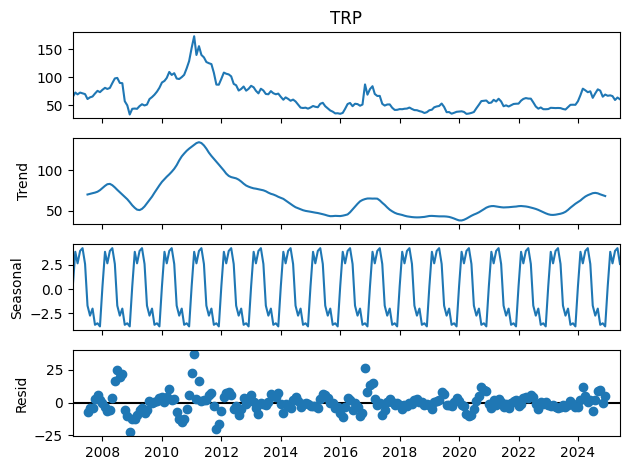

In [5]:
result = seasonal_decompose(df['TRP'], model='additive', period=12)
result.plot()
plt.show()

Available factors: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRP', 'TRPD', 'TRS', 'TRX', 'WRP']
Selected factors: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRPD', 'TRS', 'TRX', 'WRP']

Train exogenous shape: (204, 9)
Test exogenous shape: (18, 9)



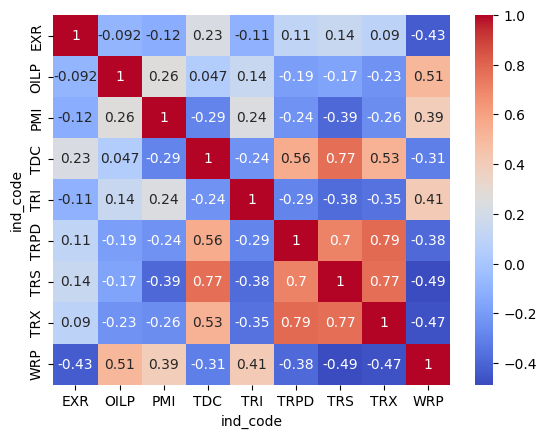

EXR: ADF Statistic = -2.7984, p-value = 0.0585
OILP: ADF Statistic = -2.9920, p-value = 0.0356
PMI: ADF Statistic = -6.2163, p-value = 0.0000
TDC: ADF Statistic = -0.2112, p-value = 0.9372
TRI: ADF Statistic = -2.2395, p-value = 0.1922
TRPD: ADF Statistic = -1.1591, p-value = 0.6909
TRS: ADF Statistic = -1.0853, p-value = 0.7209
TRX: ADF Statistic = -1.5220, p-value = 0.5226
WRP: ADF Statistic = -2.4895, p-value = 0.1180
model order: (0, 1, 0)
seasonal order: (0, 1, 1, 12)


c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                       
Dep. Variable:                                  TRP   No. Observations:                  204
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 12)   Log Likelihood                -495.749
Date:                              Tue, 25 Nov 2025   AIC                           1013.498
Time:                                      13:33:16   BIC                           1048.497
Sample:                                  01-01-2007   HQIC                          1027.691
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
EXR           -0.6171      0.001  -1098.656      0.000      -0.618      -0.616
OILP          -0.00

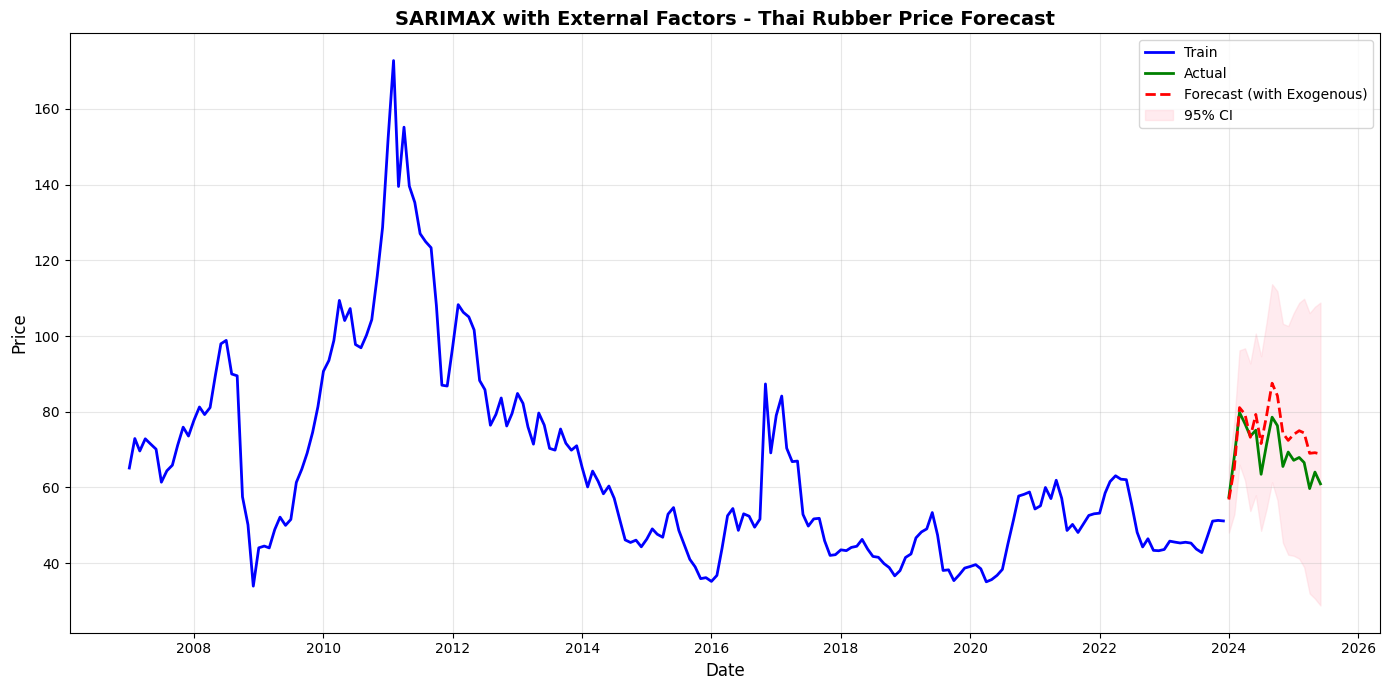

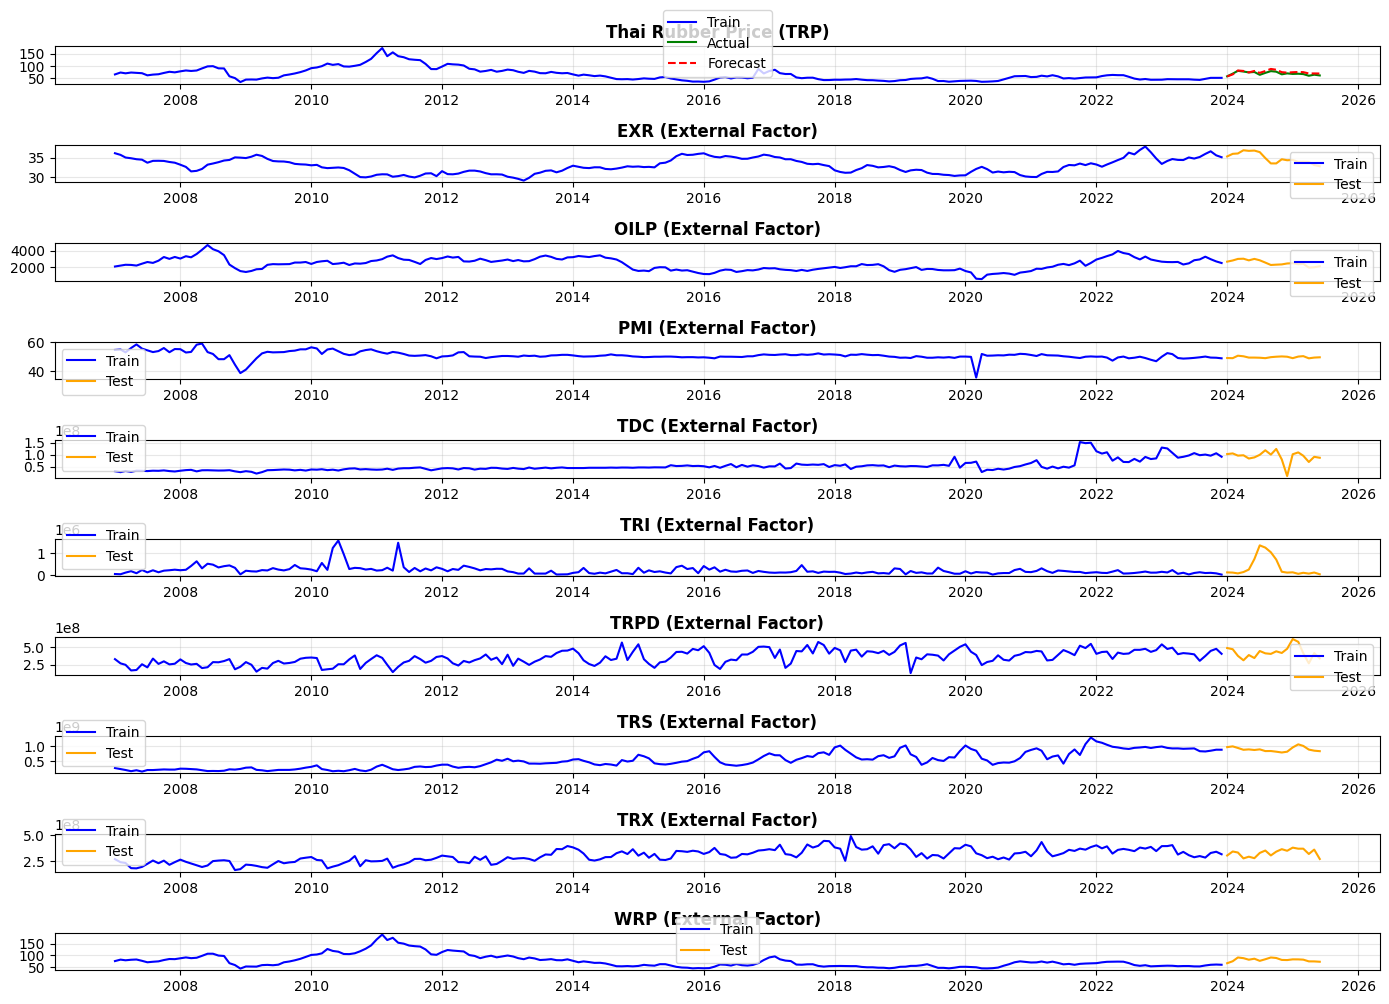

In [6]:
external_factors = ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRPD', 'TRS', 'TRX', 'WRP']

print("Available factors:", df.columns.tolist())
print("Selected factors:", [f for f in external_factors if f in df.columns])
print()

# เตรียม exogenous variables
train_exog = train_data[external_factors].copy()
test_exog = test_data[external_factors].copy()

print(f"Train exogenous shape: {train_exog.shape}")
print(f"Test exogenous shape: {test_exog.shape}\n")

# แสดง heatmap ของ correlation matrix
correlation_matrix = train_data[external_factors].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# ตรวจสอบ stationarity ของแต่ละตัวแปร
for col in external_factors:
    result = adfuller(train_data[col].dropna())
    print(f"{col}: ADF Statistic = {result[0]:.4f}, p-value = {result[1]:.4f}")

# ใช้ auto_arima หาพารามิเตอร์ที่ดีที่สุด พร้อม exogenous variables
seasonal_period = 12
model_order = (0, 1, 0)
model_seasonal_order = (0, 1, 1, seasonal_period)

print(f"model order: {model_order}")
print(f"seasonal order: {model_seasonal_order}")

# SARIMAX model พร้อม exogenous variables
sarimax_model = SARIMAX(
    train_data['TRP'],
    exog=train_exog,
    order=model_order,
    seasonal_order=model_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_results = sarimax_model.fit(disp=False)
print(sarimax_results.summary())
print()

pred_results = sarimax_results.get_prediction(
    start=len(train_data),
    end=len(train_data) + len(test_data) - 1,
    exog=test_exog, 
    dynamic=False
)

pred_mean = pred_results.predicted_mean
pred_ci = pred_results.conf_int()

# ประเมินผล
rmse = np.sqrt(mean_squared_error(test_data['TRP'], pred_mean))
mape = mean_absolute_percentage_error(test_data['TRP'], pred_mean)
accuracy = 1 - mape

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape*100:.2f}%\n")
print(f"Test Accuracy: {accuracy*100:.2f}%\n")

# วิเคราะห์ coef ของ external factors
print("External Factors Impact on Thai Rubber Price:")
coef_summary = pd.DataFrame({
    'Factor': external_factors,
    'Coefficient': sarimax_results.params[[f'exog.{i}' if f'exog.{i}' in sarimax_results.params.index 
                                          else external_factors[i] for i in range(len(external_factors))]],
})
print(coef_summary)
print()

plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['TRP'], label='Train', color='blue', linewidth=2)
plt.plot(test_data.index, test_data['TRP'], label='Actual', color='green', linewidth=2)
plt.plot(test_data.index, pred_mean, label='Forecast (with Exogenous)', 
         color='red', linewidth=2, linestyle='--')

plt.fill_between(test_data.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% CI')

plt.title('SARIMAX with External Factors - Thai Rubber Price Forecast', 
          fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# สร้าง subplot แสดง external factors
fig, axes = plt.subplots(len(external_factors) + 1, 1, figsize=(14, 10))

# Main series
axes[0].plot(train_data.index, train_data['TRP'], label='Train', color='blue')
axes[0].plot(test_data.index, test_data['TRP'], label='Actual', color='green')
axes[0].plot(test_data.index, pred_mean, label='Forecast', color='red', linestyle='--')
axes[0].set_title('Thai Rubber Price (TRP)', fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# External factors
for i, factor in enumerate(external_factors):
    axes[i+1].plot(train_data.index, train_data[factor], label='Train', color='blue')
    axes[i+1].plot(test_data.index, test_data[factor], label='Test', color='orange')
    axes[i+1].set_title(f'{factor} (External Factor)', fontweight='bold')
    axes[i+1].legend()
    axes[i+1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Auto Arima

Available factors: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRP', 'TRPD', 'TRS', 'TRX', 'WRP']
Selected factors: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRPD', 'TRS', 'TRX', 'WRP']

Train exogenous shape: (204, 9)
Test exogenous shape: (18, 9)



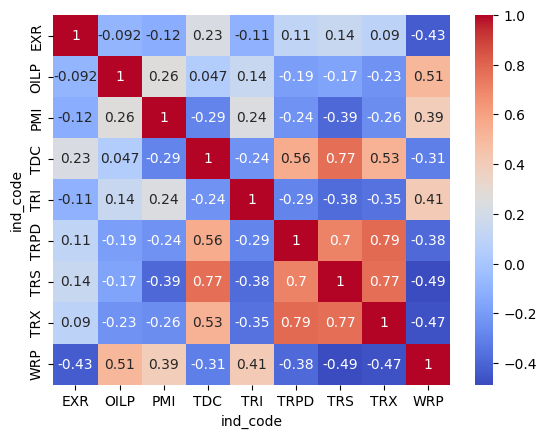

EXR: ADF Statistic = -2.7984, p-value = 0.0585
OILP: ADF Statistic = -2.9920, p-value = 0.0356
PMI: ADF Statistic = -6.2163, p-value = 0.0000
TDC: ADF Statistic = -0.2112, p-value = 0.9372
TRI: ADF Statistic = -2.2395, p-value = 0.1922
TRPD: ADF Statistic = -1.1591, p-value = 0.6909
TRS: ADF Statistic = -1.0853, p-value = 0.7209
TRX: ADF Statistic = -1.5220, p-value = 0.5226
WRP: ADF Statistic = -2.4895, p-value = 0.1180
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1434.125, Time=0.07 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1432.836, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1385.828, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.27 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1433.939, Time=0.02 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1364.080, Time=0.31 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.78 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.60 sec
 ARIMA(0,1,

c:\Users\athitan mahamon\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                TRP   No. Observations:                  204
Model:             SARIMAX(0, 1, 0)x(2, 1, 0, 12)   Log Likelihood                -476.890
Date:                            Tue, 25 Nov 2025   AIC                            977.780
Time:                                    13:33:24   BIC                           1015.196
Sample:                                01-01-2007   HQIC                           992.967
                                     - 12-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
EXR           -0.6171      0.000  -1510.454      0.000      -0.618      -0.616
OILP          -0.0006      0.002   

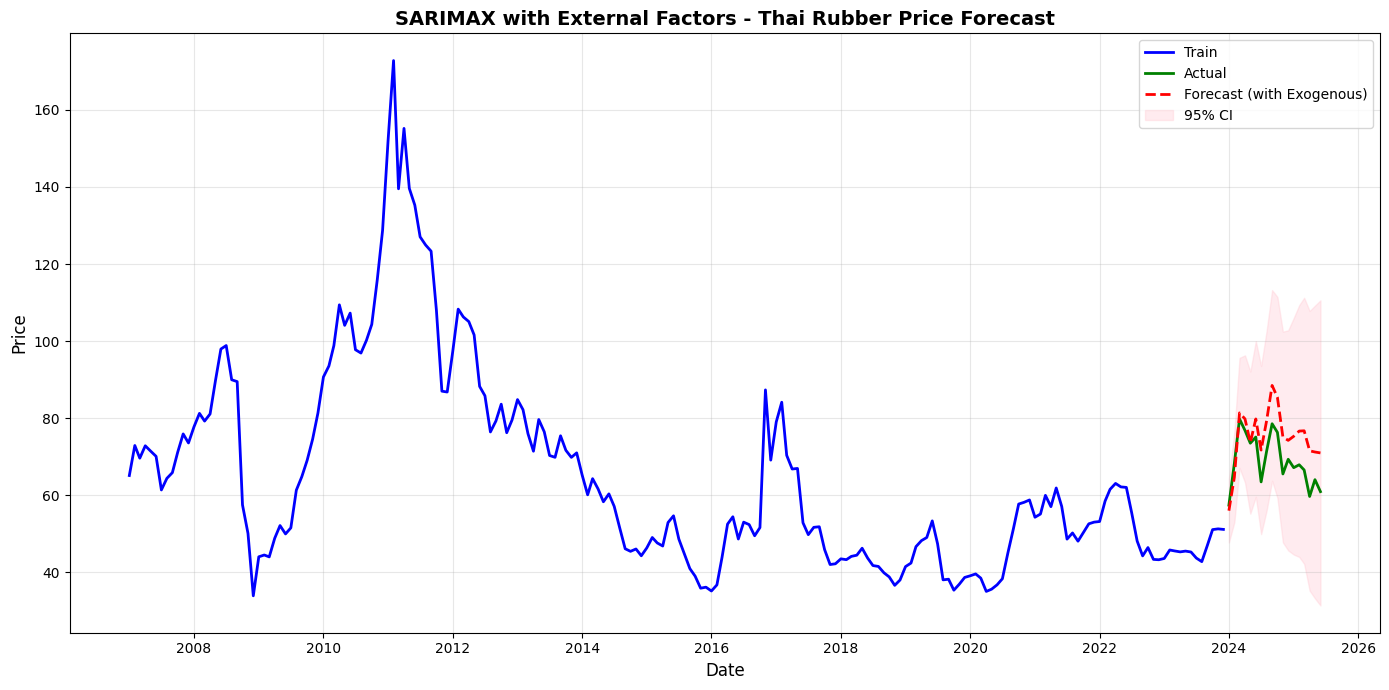

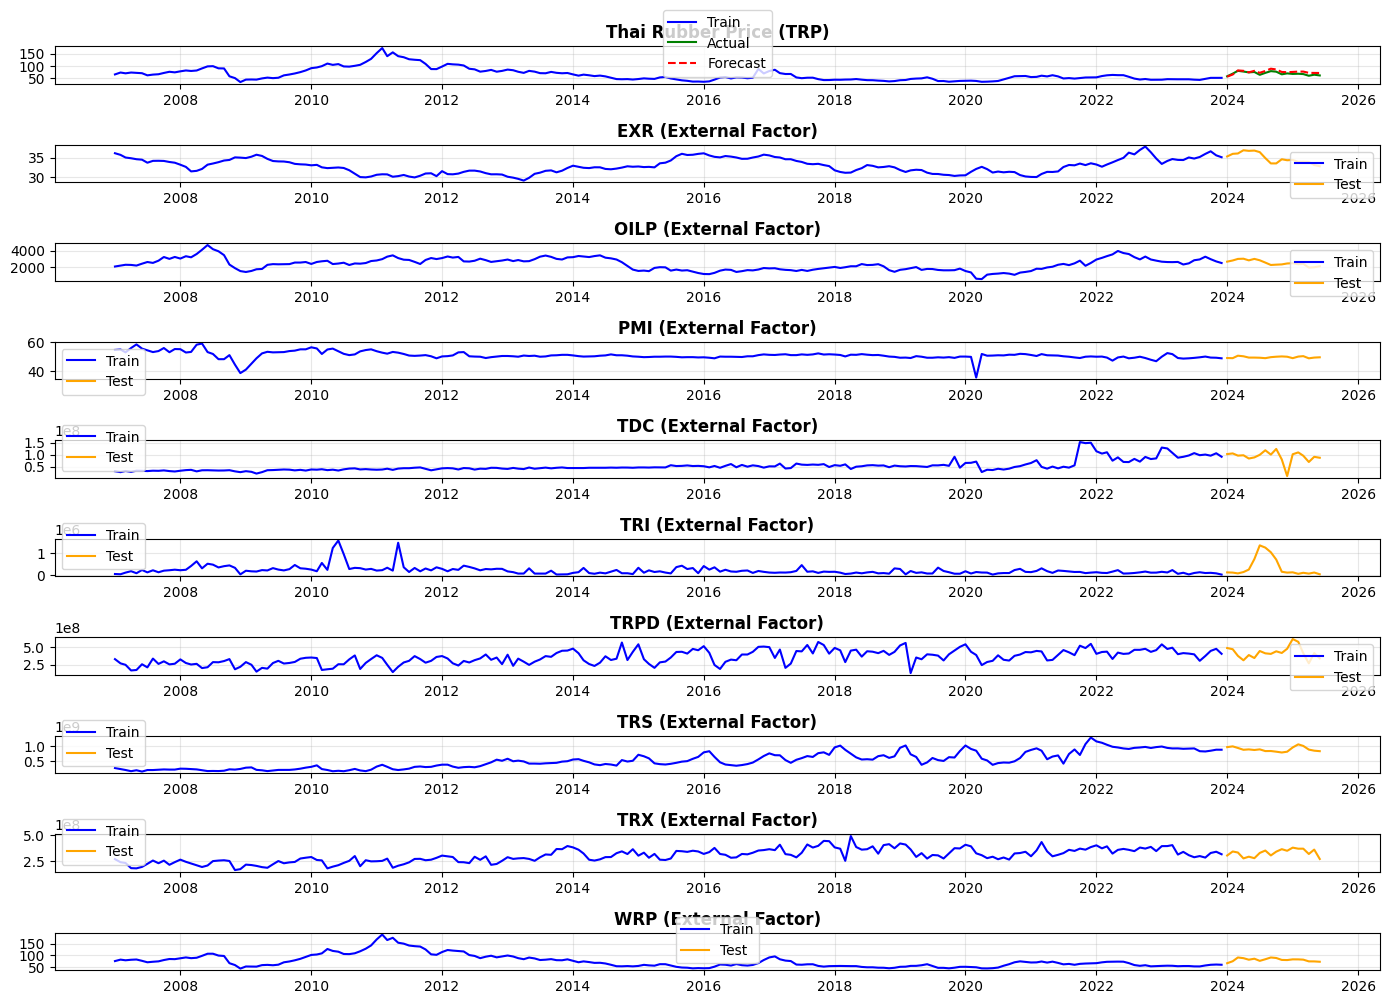

In [7]:
external_factors = ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRPD', 'TRS', 'TRX', 'WRP']

print("Available factors:", df.columns.tolist())
print("Selected factors:", [f for f in external_factors if f in df.columns])
print()

# เตรียม exogenous variables
train_exog = train_data[external_factors].copy()
test_exog = test_data[external_factors].copy()

print(f"Train exogenous shape: {train_exog.shape}")
print(f"Test exogenous shape: {test_exog.shape}\n")

# แสดง heatmap ของ correlation matrix
correlation_matrix = train_data[external_factors].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# ตรวจสอบ stationarity ของแต่ละตัวแปร
for col in external_factors:
    result = adfuller(train_data[col].dropna())
    print(f"{col}: ADF Statistic = {result[0]:.4f}, p-value = {result[1]:.4f}")

# ใช้ auto_arima หาพารามิเตอร์ที่ดีที่สุด พร้อม exogenous variables
seasonal_period = 12

model_auto_arima = auto_arima(
    train_data['TRP'],
    exogenous=train_exog,
    start_p=1, start_q=1,
    max_p=3, max_q=3,
    m=seasonal_period,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    d=1, D=1,
    seasonal=True,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
)

model_order = model_auto_arima.order
model_seasonal_order = model_auto_arima.seasonal_order

print(f"model order: {model_order}")
print(f"seasonal order: {model_seasonal_order}")

# SARIMAX model พร้อม exogenous variables
sarimax_model = SARIMAX(
    train_data['TRP'],
    exog=train_exog,
    order=model_order,
    seasonal_order=model_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_results = sarimax_model.fit(disp=False)
print(sarimax_results.summary())
print()

pred_results = sarimax_results.get_prediction(
    start=len(train_data),
    end=len(train_data) + len(test_data) - 1,
    exog=test_exog, 
    dynamic=False
)

pred_mean = pred_results.predicted_mean
pred_ci = pred_results.conf_int()

# ประเมินผล
rmse_arima = np.sqrt(mean_squared_error(test_data['TRP'], pred_mean))
mape_arima = mean_absolute_percentage_error(test_data['TRP'], pred_mean)
accuracy_arima = 1 - mape_arima

print(f"Test RMSE: {rmse_arima:.4f}")
print(f"Test MAPE: {mape_arima*100:.2f}%\n")
print(f"Test Accuracy: {accuracy_arima*100:.2f}%\n")

# วิเคราะห์ coef ของ external factors
print("External Factors Impact on Thai Rubber Price:")
coef_summary = pd.DataFrame({
    'Factor': external_factors,
    'Coefficient': sarimax_results.params[[f'exog.{i}' if f'exog.{i}' in sarimax_results.params.index 
                                          else external_factors[i] for i in range(len(external_factors))]],
})
print(coef_summary)
print()

plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_data['TRP'], label='Train', color='blue', linewidth=2)
plt.plot(test_data.index, test_data['TRP'], label='Actual', color='green', linewidth=2)
plt.plot(test_data.index, pred_mean, label='Forecast (with Exogenous)', 
         color='red', linewidth=2, linestyle='--')

plt.fill_between(test_data.index,
                 pred_ci.iloc[:, 0],
                 pred_ci.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% CI')

plt.title('SARIMAX with External Factors - Thai Rubber Price Forecast', 
          fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# สร้าง subplot แสดง external factors
fig, axes = plt.subplots(len(external_factors) + 1, 1, figsize=(14, 10))

# Main series
axes[0].plot(train_data.index, train_data['TRP'], label='Train', color='blue')
axes[0].plot(test_data.index, test_data['TRP'], label='Actual', color='green')
axes[0].plot(test_data.index, pred_mean, label='Forecast', color='red', linestyle='--')
axes[0].set_title('Thai Rubber Price (TRP)', fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# External factors
for i, factor in enumerate(external_factors):
    axes[i+1].plot(train_data.index, train_data[factor], label='Train', color='blue')
    axes[i+1].plot(test_data.index, test_data[factor], label='Test', color='orange')
    axes[i+1].set_title(f'{factor} (External Factor)', fontweight='bold')
    axes[i+1].legend()
    axes[i+1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Auto Arima wiht PCA

Available factors: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRP', 'TRPD', 'TRS', 'TRX', 'WRP']
Selected factors: ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRPD', 'TRS', 'TRX', 'WRP']

Train exogenous shape: (204, 9)
Test exogenous shape: (18, 9)


Finding Optimal PCA Components

2 Components: Explained Variance = 59.21%
  RMSE: 15.0063, MAPE: 19.70%, AIC: 1167.35

3 Components: Explained Variance = 70.45%
  RMSE: 13.0716, MAPE: 15.01%, AIC: 1161.13

4 Components: Explained Variance = 79.49%
  RMSE: 13.4796, MAPE: 15.55%, AIC: 1137.33

5 Components: Explained Variance = 88.21%
  RMSE: 12.8593, MAPE: 14.68%, AIC: 1137.99

6 Components: Explained Variance = 92.79%
  RMSE: 13.6608, MAPE: 15.43%, AIC: 1136.56

7 Components: Explained Variance = 96.21%
  RMSE: 7.7581, MAPE: 10.21%, AIC: 1045.55

8 Components: Explained Variance = 98.55%
  RMSE: 7.9098, MAPE: 10.25%, AIC: 974.10

9 Components: Explained Variance = 100.00%
  RMSE: 7.9608, MAPE: 10.32%, AIC: 969.52

Summary:
 Components Explained Var 

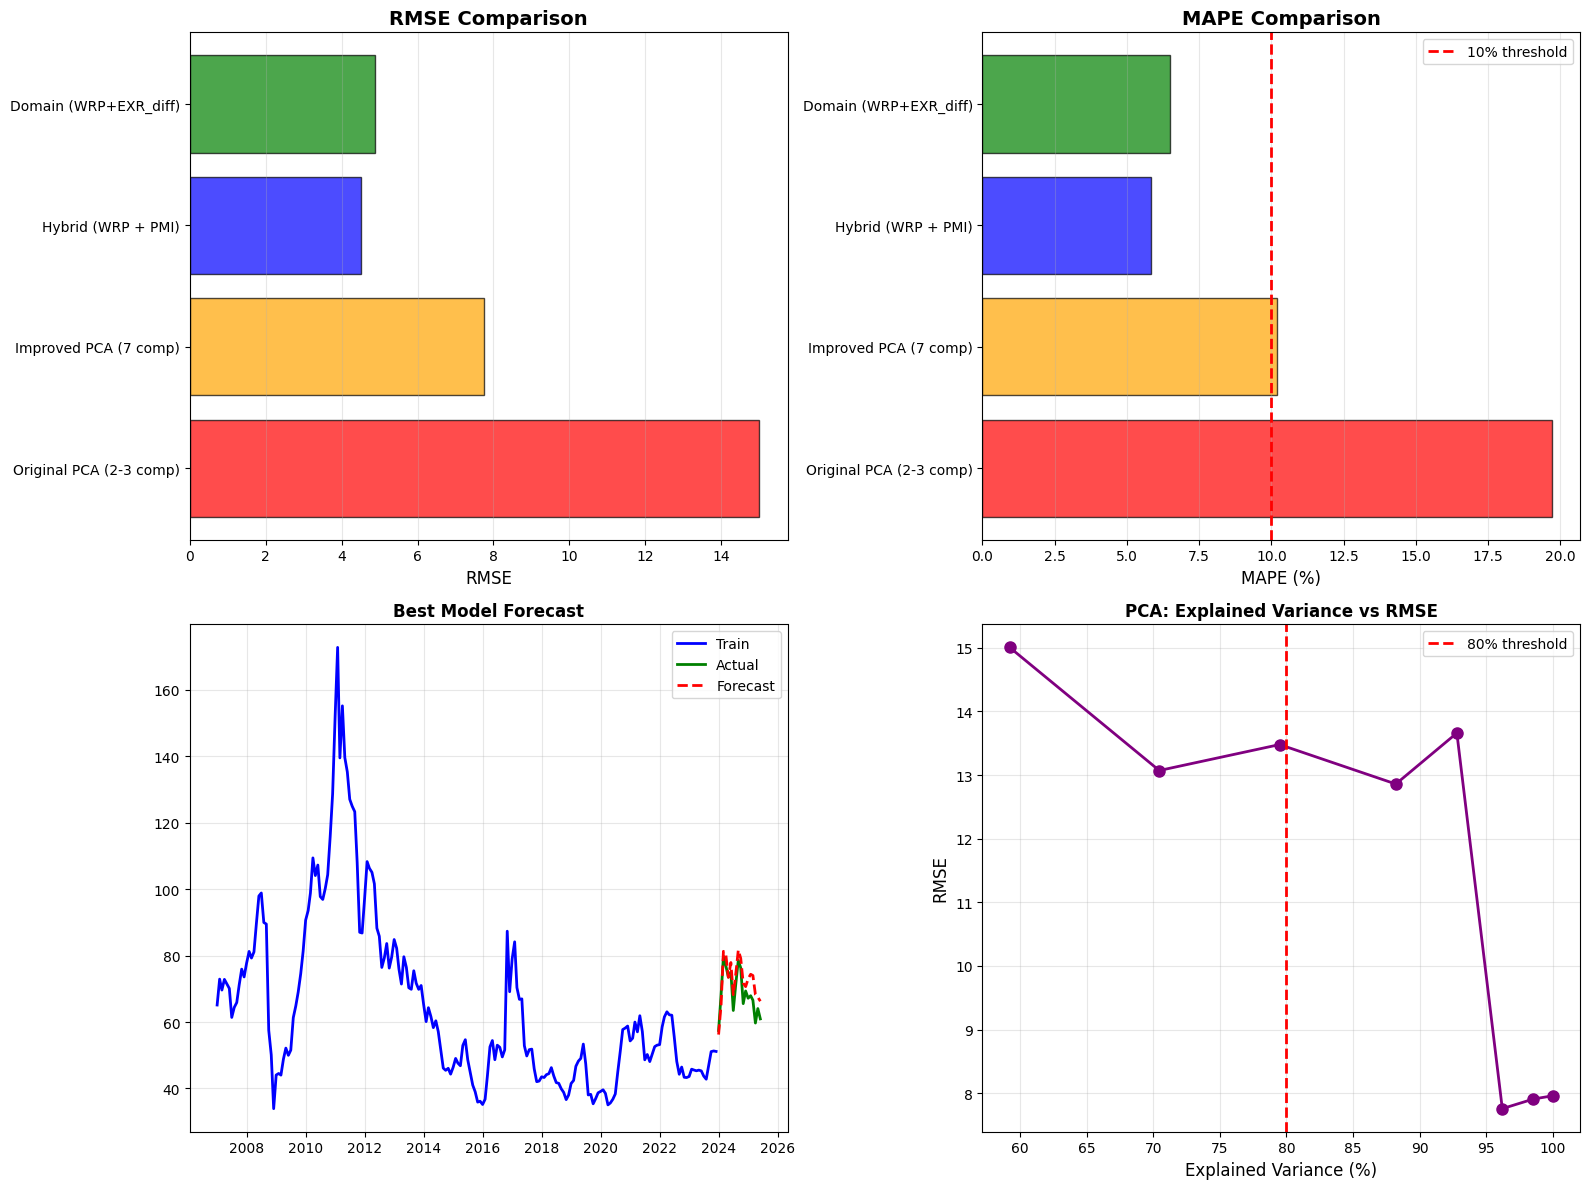

In [8]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.tsa.statespace.sarimax import SARIMAX

external_factors = ['EXR', 'OILP', 'PMI', 'TDC', 'TRI', 'TRPD', 'TRS', 'TRX', 'WRP']

print("Available factors:", df.columns.tolist())
print("Selected factors:", [f for f in external_factors if f in df.columns])
print()

# เตรียม exogenous variables
train_exog = train_data[external_factors].copy()
test_exog = test_data[external_factors].copy()

print(f"Train exogenous shape: {train_exog.shape}")
print(f"Test exogenous shape: {test_exog.shape}\n")

# Standardize เตรียมข้อมูลก่อนไปทำ PCA 
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_exog)
test_scaled = scaler.transform(test_exog)

# ใช้ PCA หาจำนวน components ที่เหมาะสม
print("\nFinding Optimal PCA Components")
approach1_results = []

for n_comp in range(2, 10):
    pca = PCA(n_components=n_comp)
    train_pca = pd.DataFrame(
        pca.fit_transform(train_scaled),
        index=train_data.index,
        columns=[f'PC{i+1}' for i in range(n_comp)]
    )
    test_pca = pd.DataFrame(
        pca.transform(test_scaled),
        index=test_data.index,
        columns=[f'PC{i+1}' for i in range(n_comp)]
    )
    
    explained_var = sum(pca.explained_variance_ratio_)
    
    print(f"\n{n_comp} Components: Explained Variance = {explained_var*100:.2f}%")
    
    try:
        # Train model
        model_auto = auto_arima(
            train_data['TRP'], exogenous=train_pca,
            start_p=0, start_q=0,
            max_p=2, max_q=2,
            m=12,
            start_P=0,
            max_P=2, max_Q=2,
            d=1, D=1,
            seasonal=True,
            stepwise=True,
            suppress_warnings=True,
            trace=False,
            maxiter=200
        )
        
        sarimax_fit = SARIMAX(
            train_data['TRP'],
            exog=train_pca,
            order=model_auto.order,
            seasonal_order=model_auto.seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        ).fit(disp=False)
        
        pred_mean = sarimax_fit.get_prediction(
            start=len(train_data), 
            end=len(train_data) + len(test_data)-1,
            exog=test_pca, 
            dynamic=False
        ).predicted_mean
        
        rmse = np.sqrt(mean_squared_error(test_data['TRP'], pred_mean))
        mape = mean_absolute_percentage_error(test_data['TRP'], pred_mean) * 100
        
        approach1_results.append({
            'n_components': n_comp,
            'explained_var': explained_var,
            'RMSE': rmse,
            'MAPE': mape,
            'AIC': sarimax_fit.aic,
            'model': sarimax_fit,
            'pred': pred_mean
        })
        
        print(f"  RMSE: {rmse:.4f}, MAPE: {mape:.2f}%, AIC: {sarimax_fit.aic:.2f}")
        
    except Exception as e:
        print(f"Error: {str(e)[:80]}")

print("\nSummary:")
results1_df = pd.DataFrame([
    {
        'Components': r['n_components'],
        'Explained Var': f"{r['explained_var']*100:.1f}%",
        'RMSE': r['RMSE'],
        'MAPE': f"{r['MAPE']:.2f}%",
        'AIC': r['AIC']
    }
    for r in approach1_results
])
print(results1_df.to_string(index=False))

best1 = min(approach1_results, key=lambda x: x['RMSE'])
print(f"Best: {best1['n_components']} components")
print(f"Explained Variance: {best1['explained_var']*100:.2f}%")
print(f"RMSE: {best1['RMSE']:.4f}")
print(f"MAPE: {best1['MAPE']:.2f}%")


print("\n\nHybrid Approach (Key Factors + PCA)")
# ลองทดสอบเอาปัจจัยหลายแบบมารวมกันว่าอะไรเป็น key factors ที่ดีที่สุด
key_factor_combinations = [
    (['WRP'], 'WRP only'),
    (['WRP', 'EXR'], 'WRP + EXR'),
    (['WRP', 'PMI'], 'WRP + PMI'),
    (['WRP', 'EXR', 'PMI'], 'WRP + EXR + PMI')
]

approach2_results = []

for key_factors, name in key_factor_combinations:
    print(f"Testing: {name}")
    print(f"Key factors: {key_factors}")
    
    other_factors = [f for f in external_factors if f not in key_factors]
    print(f"PCA factors: {other_factors}")
    
    other_scaled = scaler.fit_transform(train_exog[other_factors])
    other_scaled_test = scaler.transform(test_exog[other_factors])
    
    for n_pca in [2, 3, 4]:
        if n_pca > len(other_factors):
            continue
            
        pca = PCA(n_components=n_pca)
        other_pca = pca.fit_transform(other_scaled)
        other_pca_test = pca.transform(other_scaled_test)
        
        train_hybrid = pd.DataFrame(index=train_data.index)
        test_hybrid = pd.DataFrame(index=test_data.index)
        
        for kf in key_factors:
            train_hybrid[kf] = train_exog[kf].values
            test_hybrid[kf] = test_exog[kf].values
        
        for i in range(n_pca):
            train_hybrid[f'PC{i+1}'] = other_pca[:, i]
            test_hybrid[f'PC{i+1}'] = other_pca_test[:, i]
        
        explained_var = sum(pca.explained_variance_ratio_)
        
        try:
            # Train
            model_auto = auto_arima(
                train_data['TRP'], exogenous=train_hybrid,
                start_p=0, start_q=0, max_p=2, max_q=2,
                m=12, start_P=0, max_P=2, max_Q=2,
                d=1, D=1, seasonal=True, stepwise=True,
                suppress_warnings=True, trace=False
            )
            
            sarimax_fit = SARIMAX(
                train_data['TRP'], exog=train_hybrid,
                order=model_auto.order, seasonal_order=model_auto.seasonal_order,
                enforce_stationarity=False, enforce_invertibility=False
            ).fit(disp=False)
            
            pred_mean = sarimax_fit.get_prediction(
                start=len(train_data), end=len(train_data)+len(test_data)-1,
                exog=test_hybrid, dynamic=False
            ).predicted_mean
            
            rmse = np.sqrt(mean_squared_error(test_data['TRP'], pred_mean))
            mape = mean_absolute_percentage_error(test_data['TRP'], pred_mean) * 100
            
            approach2_results.append({
                'name': name,
                'key_factors': key_factors,
                'n_pca': n_pca,
                'total_features': len(key_factors) + n_pca,
                'explained_var_pca': explained_var,
                'RMSE': rmse,
                'MAPE': mape,
                'AIC': sarimax_fit.aic,
                'model': sarimax_fit,
                'pred': pred_mean
            })
            
            print(f"{len(key_factors)} key + {n_pca} PCA = {len(key_factors)+n_pca} total")
            print(f"PCA explains {explained_var*100:.1f}% of other factors")
            print(f"RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")
            
        except Exception as e:
            print(f"Error: {str(e)[:60]}")

print("\nSummary:")
results2_df = pd.DataFrame([
    {
        'Strategy': r['name'],
        'Total Feat': r['total_features'],
        'RMSE': r['RMSE'],
        'MAPE': f"{r['MAPE']:.2f}%",
        'AIC': r['AIC']
    }
    for r in approach2_results
])
print(results2_df.to_string(index=False))

best2 = min(approach2_results, key=lambda x: x['RMSE'])
print(f"Best Hybrid:")
print(f"Strategy: {best2['name']}")
print(f"Key factors: {best2['key_factors']}")
print(f"PCA components: {best2['n_pca']}")
print(f"Total features: {best2['total_features']}")
print(f"RMSE: {best2['RMSE']:.4f}")
print(f"MAPE: {best2['MAPE']:.2f}%")


print("FINAL")
all_approaches = [
    {'Method': 'Original PCA (2-3 comp)', 'RMSE': 15.0063, 'MAPE': 19.70, 'Note': 'Your current result'},
    {'Method': f'Improved PCA ({best1["n_components"]} comp)', 
     'RMSE': best1['RMSE'], 'MAPE': best1['MAPE'], 
     'Note': f'Explained {best1["explained_var"]*100:.1f}%'},
    {'Method': f'Hybrid ({best2["name"]})', 
     'RMSE': best2['RMSE'], 'MAPE': best2['MAPE'],
     'Note': f'{best2["total_features"]} features total'},
    {'Method': 'Domain (WRP+EXR_diff)', 'RMSE': 4.88, 'MAPE': 6.48, 'Note': 'Reference from before'}
]

comparison_df = pd.DataFrame(all_approaches)
print(comparison_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# RMSE 
ax = axes[0, 0]
methods = [a['Method'] for a in all_approaches]
rmses = [a['RMSE'] for a in all_approaches]
colors = ['red', 'orange', 'blue', 'green']
ax.barh(methods, rmses, color=colors, edgecolor='black', alpha=0.7)
ax.set_xlabel('RMSE', fontsize=12)
ax.set_title('RMSE Comparison', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# MAPE
ax = axes[0, 1]
mapes = [a['MAPE'] for a in all_approaches]
ax.barh(methods, mapes, color=colors, edgecolor='black', alpha=0.7)
ax.axvline(x=10, color='red', linestyle='--', label='10% threshold', linewidth=2)
ax.set_xlabel('MAPE (%)', fontsize=12)
ax.set_title('MAPE Comparison', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='x')

ax = axes[1, 0]
best_overall = best2 if best2['RMSE'] < best1['RMSE'] else best1
ax.plot(train_data.index, train_data['TRP'], label='Train', color='blue', linewidth=2)
ax.plot(test_data.index, test_data['TRP'], label='Actual', color='green', linewidth=2)
ax.plot(test_data.index, best_overall['pred'], label='Forecast', 
        color='red', linewidth=2, linestyle='--')
ax.set_title(f'Best Model Forecast', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1, 1]
exp_vars = [r['explained_var']*100 for r in approach1_results]
rmses_pca = [r['RMSE'] for r in approach1_results]
ax.plot(exp_vars, rmses_pca, 'o-', linewidth=2, markersize=8, color='purple')
ax.set_xlabel('Explained Variance (%)', fontsize=12)
ax.set_ylabel('RMSE', fontsize=12)
ax.set_title('PCA: Explained Variance vs RMSE', fontsize=12, fontweight='bold')
ax.axvline(x=80, color='red', linestyle='--', label='80% threshold', linewidth=2)
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

Performance Camparison

In [9]:
data = {
    'Model': ['Baseline', 'Auto Arima Tuning'],
    'RMSE': [rmse, rmse_arima],
    'MAPE': [mape, mape_arima],
    'ACCURACY': [accuracy, accuracy_arima]
}
df_comparison = pd.DataFrame(data)

df_comparison['MAPE (%)'] = (df_comparison['MAPE'] * 100).map('{:.2f}%'.format)
df_comparison['ACCURACY (%)'] = (df_comparison['ACCURACY'] * 100).map('{:.2f}%'.format)

df_display = df_comparison[['Model', 'RMSE', 'MAPE (%)', 'ACCURACY (%)']]

print("Performance Comparison\n")
print(df_display.to_string(index=True, col_space=10))

Performance Comparison

                        Model       RMSE   MAPE (%) ACCURACY (%)
0                    Baseline   7.983129   1038.93%       91.76%
1           Auto Arima Tuning   7.507596      9.90%       90.10%
